<img src="\.\Files\pass-summit-virtual-2020.png" width="600">

Before we get started, we will load a copy of the data set sent to R from Power BI. Note that clicking the 45-degree arrow in Power BI R script editor would have open up R Studio, and that is where the development would have been done. But we will use a Jupyter Notebook to describe the process because of the rich annotations we can use to describe the code.

The code in the first cell below reads in the data into the Jupyter Notebook session and the second cell below uses the str() function to inspect the "structure" of the ***dataset*** data frame.

In [1]:
`dataset` = read.csv('input.csv', check.names = FALSE, encoding = "UTF-8", blank.lines.skip = FALSE);

In [2]:
str(dataset)

'data.frame':	119 obs. of  3 variables:
 $ Country       : Factor w/ 119 levels "Afghanistan",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ Total Expend %: num  0.141 0.1212 0.0804 0.1446 0.1114 ...
 $ Year          : int  2013 2013 2013 2013 2013 2013 2013 2013 2013 2013 ...


# 1. Load Required R Packages
- The **repr** packages is used to resize the charts
- The **ggplot2** package is used to create the data visualization
- The **ggthemes** package is used to add a predifined themes to the chart
- The **dplyr**, **forcats**, **stringr**, and **scales** packages are used to perform some data wrangling and string manipulation tasks

In [3]:
library("repr")
library("ggplot2")
library("ggthemes")
library("dplyr")
library("forcats")
library("stringr")
library("scales")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# 2. Create Data Validation Test

#### Basic template for R scripts used to create R Visuals in Power BI
Below is the basic template used to create R visuals in Power BI. The template first test to see if the data meets the requirements of the R visual being produced. If it does, code will be executed that generates the visual. If it does not, then a blank plot will be created that shares information to the end-user why the visual was not produced.

```R
if (<”data test”>) {

     #<"Code for R Visual"> 

} else { 

     plot.new() 
     title(main = "<predefined message>") 

}
```

### Variables needed to perform the validation test
In order to create the visual, the data set passed to R must contain the required columns as well as one year's worth of data. The ***currentColumn*** variable contains the name of the columns in the data set passed to R, the ***requiredColumns*** character vector is a pre-defined list of the required columns, ***columnTest*** contains the results of the comparison test between ***currentColumns*** and ***requiredColumns***, and the ***reportYear*** variable contains the unique list of years in the data set.

In [4]:
x = c(1, 2, 3)
y = c(1, 2)
all.equal(x, y)

[1] "Numeric: lengths (3, 2) differ"

In [5]:
x = c(1, 2, 3)
y = c(1, 2, 3)
all.equal(x, y)

[1] TRUE

In [6]:
x = c(1, 2, 3)
y = c(1, 2)
isTRUE(all.equal(x, y))

[1] FALSE

In [7]:
currentColumns <- sort(colnames(dataset))
requiredColumns <- c("Country", "Total Expend %", "Year")
columnTest <- isTRUE(all.equal(currentColumns, requiredColumns))
reportYear <- unique(dataset$Year)

### Implement the validation variables in the template
The validation variables are implemented in the template to check if the data set meets the required conditions of the R visual. In this instance, the data set must only represent one year's worth of data, and the ***columnTest*** must evaluate to ***True***.

In [8]:
if (length(reportYear) == 1 & columnTest == TRUE) {
  
      print("Passed Test!!!"
           )
} else {
    
  plot.new()
  title("The data supplied did not meet the requirements of the chart.")

}


[1] "Passed Test!!!"


# 3. Make necessary transformations to the data set
You are not limited to using the data set that is passed to R from Power BI "as is". You can make further transformations to the data set before you visualize it. Below, we are adding three columns:  ***rank***, ***Country***, and ***callout***. The ***rank*** column holds the ranking of the ***Total Expend %*** column, The ***Country*** is the same as the previous version except the order has been changed based on the ***rank*** column, and the ***callout*** column was created to make it easy to identify country we need to highlight. Lastly, we filter the top 7 countries using the ***filter()*** function.

In [9]:
plotdata <- 
  dataset %>%
  mutate(
    rank = dense_rank(desc(`Total Expend %`)),
    Country = fct_reorder(`Country`, rank, .desc = TRUE), 
    callout = ifelse(rank == 1, TRUE, FALSE)
  ) %>%
  filter(rank <= 7)

plotdata

Country,Total Expend %,Year,rank,callout
<fct>,<dbl>,<int>,<int>,<lgl>
Belize,0.2224,2013,7,FALSE
Benin,0.2234,2013,6,FALSE
Costa Rica,0.2283,2013,5,FALSE
Ethiopia,0.2702,2013,2,FALSE
Senegal,0.2574,2013,3,FALSE
Uzbekistan,0.2332,2013,4,FALSE
Zimbabwe,0.2866,2013,1,TRUE


# 4. Define the dynamic elements of the chart
### Create the variables used for the chart titles and the dynamic annotations 
One of the nice features about the ggplot2 package is how easy is to add dynamic text to your visualization. Below is the code needed to create the chart title, the dynamic chart subtitle, the chart caption, and the dynamic chart annotation.

Creates the main chart title, the chart subtitle, and the chart caption.

In [10]:
mainTitle = "% of Government Expenditure on Education"
subTitle = paste(
                 "The top 7 ranked countries in", 
                 reportYear, 
                 sep = " ")
caption = "Source: https://databank.worldbank.org/source/world-development-indicators"

Gets the country that is rank number 1. This information is later used in the visualization. Note how the code below returns a boolean vector that is used to subset the Country field to find the country that is rank number 1.

In [11]:
plotdata$rank == 1

[1] FALSE FALSE FALSE FALSE FALSE FALSE  TRUE

In [12]:
countryToAnnotate <- plotdata$`Country`[plotdata$rank == 1]
countryToAnnotate

[1] Zimbabwe
119 Levels: South Sudan Liberia Timor-Leste Azerbaijan Monaco ... Zimbabwe

The code below creates variables used to create the variables used to hold the minimum values that will be used in the annotation.

In [13]:
minExpenditure <- min(plotdata$`Total Expend %`)
minCountry <- plotdata$`Country`[plotdata$`Total Expend %` == minExpenditure]
minCountry <- paste(minCountry, collapse = " & ") 

The code below creates variables used to create the variables used to hold the maximum values that will be used in the annotation.

In [14]:
maxExpenditure <- max(plotdata$`Total Expend %`)
maxCountry <- plotdata$`Country`[plotdata$`Total Expend %` == maxExpenditure]
maxCountry <- paste(maxCountry, collapse = " & ")

The variable below is used to hold the annotation that will be displayed in the chart

In [15]:
label_val <- 
  str_wrap(
           paste(
                 maxCountry, 
                 "spent",  
                 percent((maxExpenditure/minExpenditure-1)), 
                 "more than", 
                 minCountry, 
                 sep = " "
           ),
           width = 25
  )

# 5. Build the chart using ***ggplot2***

The code below initializes the chart's creation using the ***ggplot()*** function from the ***ggplot2*** package. The two arguments that are defined are the ***data*** argument and the ***mapping*** argument. The ***data*** argument is used to define the visual's data source, and the ***mapping*** argument is used to map the data to aesthetics in the visual.

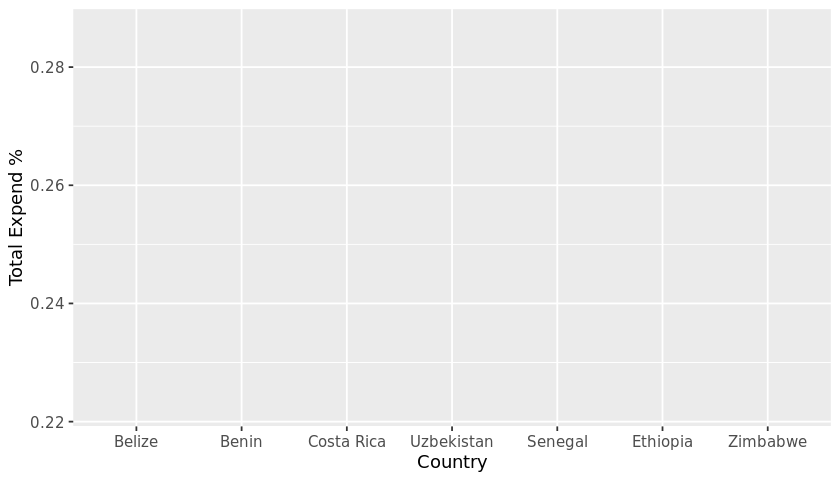

In [16]:
options(repr.plot.width=7, repr.plot.height=4)
p <- 
  ggplot(
    data = plotdata, 
    mapping = aes(x = `Country`, y = `Total Expend %`, fill = callout, label = percent(`Total Expend %`))
  )
p

The code in the previous cell produced a blank chart because it did not contain any layers. Below we add the first layer to the chart. We are adding a ***bar chart*** to the visual via the ***geom_bar*** geom. The code below adds the bar columns to the chart. The ***stat*** argument is used to determine what values the bar displays. The default value is ***bin***. That option makes the height of each bar equal to the number of cases in each group. We don't want that. We want the value contained in the column mapped to the ***y axis***. We set the ***stat*** argument to ***identity*** to make that happen. 

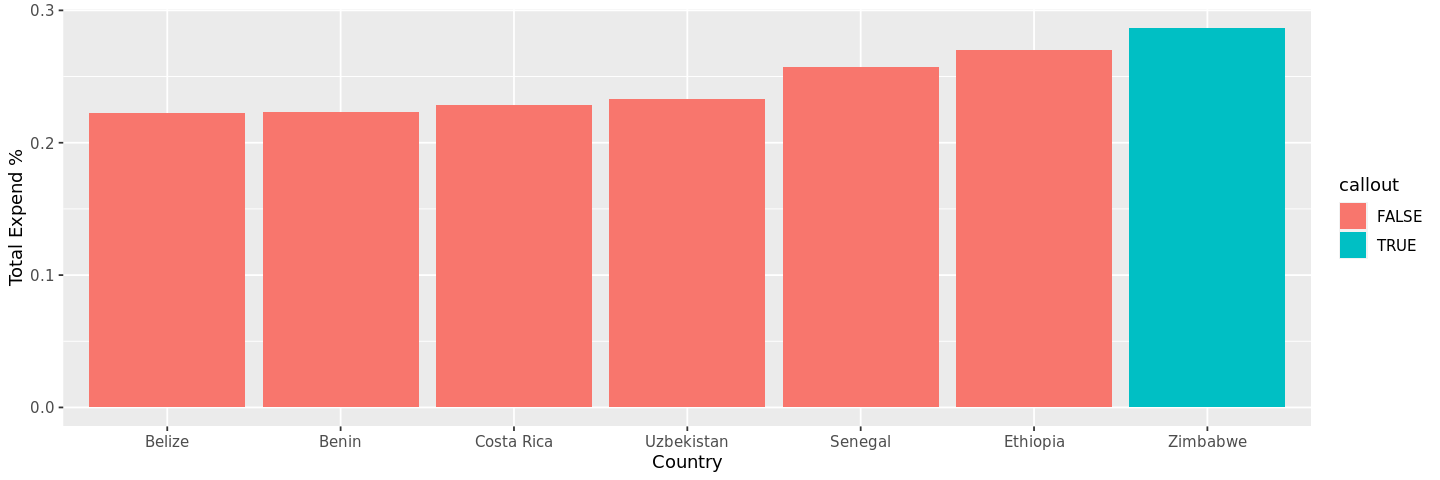

In [17]:
options(repr.plot.width=12, repr.plot.height=4)
p <- 
  ggplot(
    data = plotdata, 
    mapping = aes(x = `Country`, y = `Total Expend %`, fill = callout, label = percent(`Total Expend %`))
  ) +
  geom_bar(stat="identity")

p

The code adds another layer to the chart that contains the labels. This is accomplished using the ***geom_text*** geom. The only argument that is defined is the ***nudge_y*** argument. By default, the labels are position outside the bars. Setting the value to -0.05 positions the value inside the bars. We did not need to pass any other arguments to ***geom_text*** because it inherited the ***data*** and ***aesthetics*** from the ***ggplot*** function.

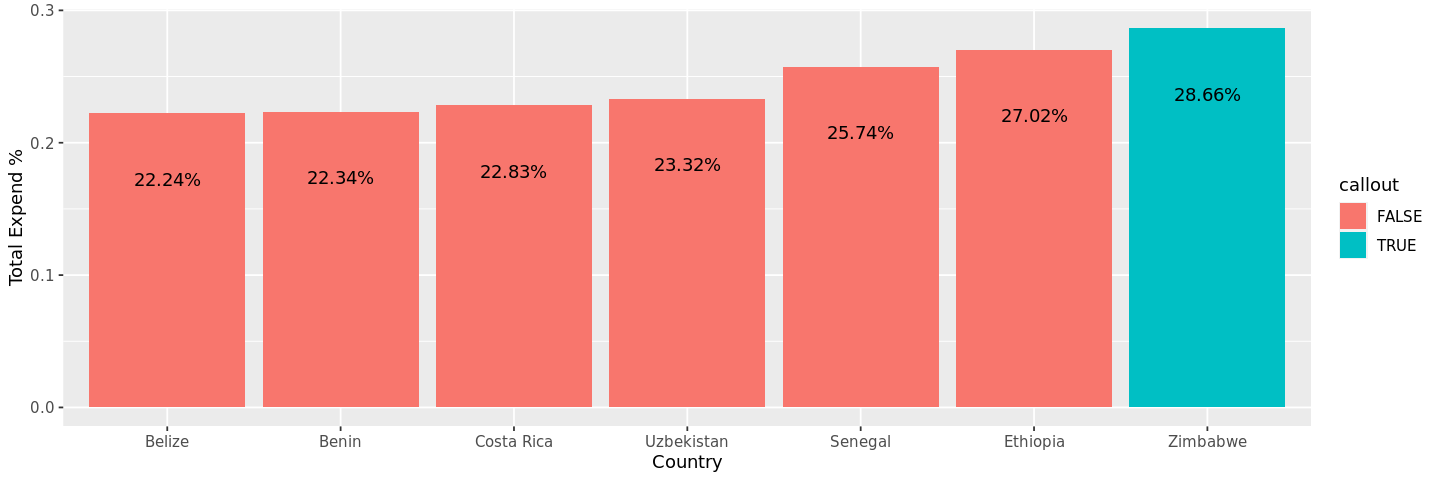

In [18]:
options(repr.plot.width=12, repr.plot.height=4)
p <- 
  ggplot(
    data = plotdata, 
    mapping = aes(x = `Country`, y = `Total Expend %`, fill = callout, label = percent(`Total Expend %`))
  ) +
  geom_bar(stat="identity") +
  geom_text(nudge_y = -0.05)
p

Next, we add code to the chart to fix the y-axis range between 0 and 0.75. If this is not done, then the y-axis could get rescaled when a new selection is made, which can be visually misleading.

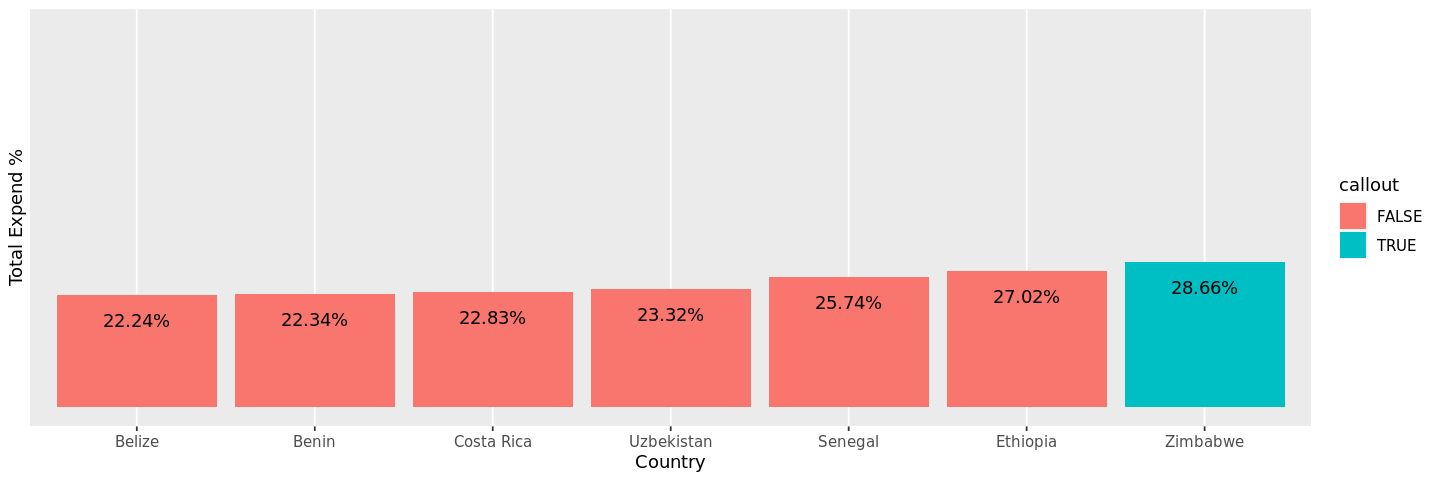

In [19]:
options(repr.plot.width=12, repr.plot.height=4)
p <- 
  ggplot(
    data = plotdata, 
    mapping = aes(x = `Country`, y = `Total Expend %`, fill = callout, label = percent(`Total Expend %`))
  ) +
  geom_bar(stat="identity", mapping = aes(fill = callout)) +
  geom_text(nudge_y = -0.05) +
  scale_y_continuous(
  limits = c(0,0.75), labels = NULL, breaks = NULL)
p

Next, we add code that switches the chart from a vertical bar chart to a horizontal chart via the ***coord_flip*** function

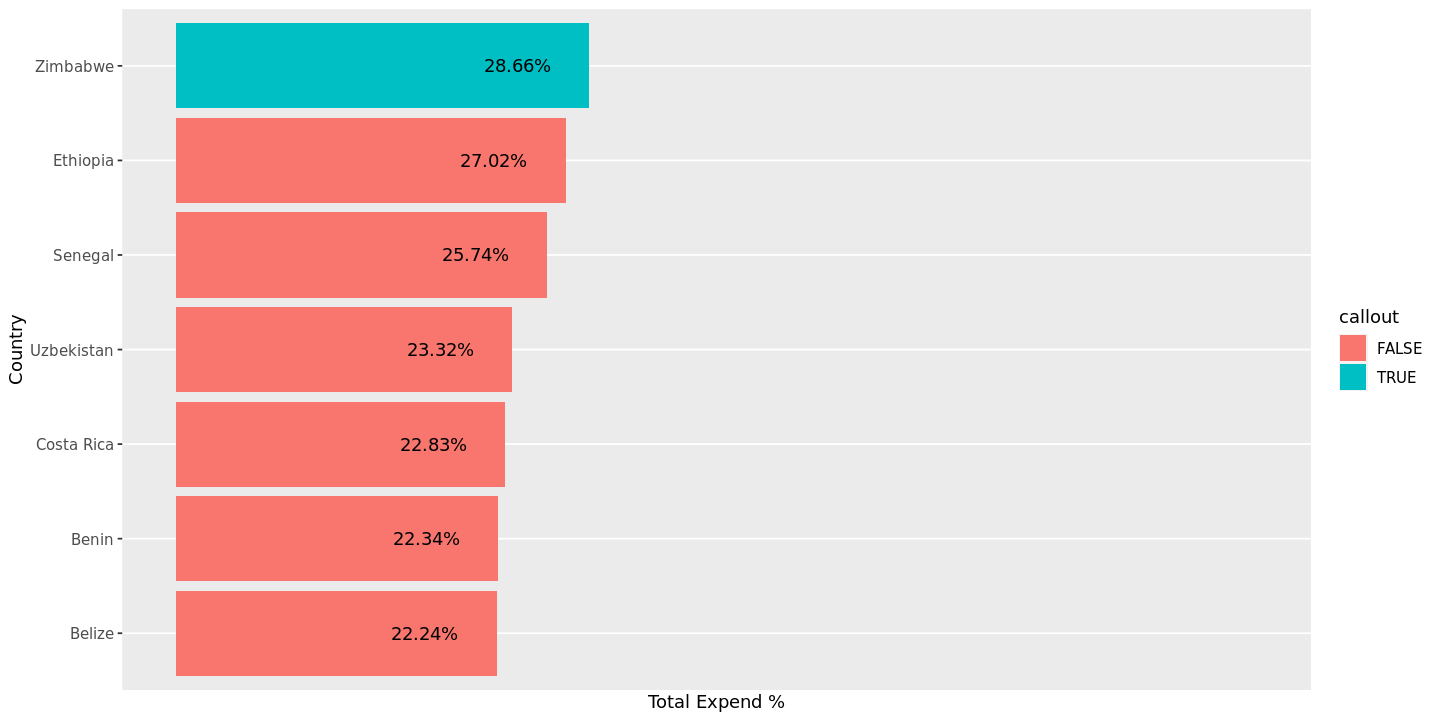

In [20]:
options(repr.plot.width=12, repr.plot.height=6)
p <- 
  ggplot(
    data = plotdata, 
    mapping = aes(x = `Country`, y = `Total Expend %`, fill = callout, label = percent(`Total Expend %`))
  ) +
  geom_bar(stat="identity", aes(fill = callout)) +
  geom_text(nudge_y = -0.05) +
  scale_y_continuous(limits = c(0,0.75), labels = NULL, breaks = NULL) +
  coord_flip()
p

Next, we add the dynamic annotation to the chart. The dynamic annotation is supplied via the ***label_val*** variable that was defined earlier. The x-axis position is determined using the ***countryToAnnotate*** variable's value, and the y-axis position is determined by adding 0.1 to the ***maxExpenditure*** variable. This helps prevent the annotation from overlaying the bars.

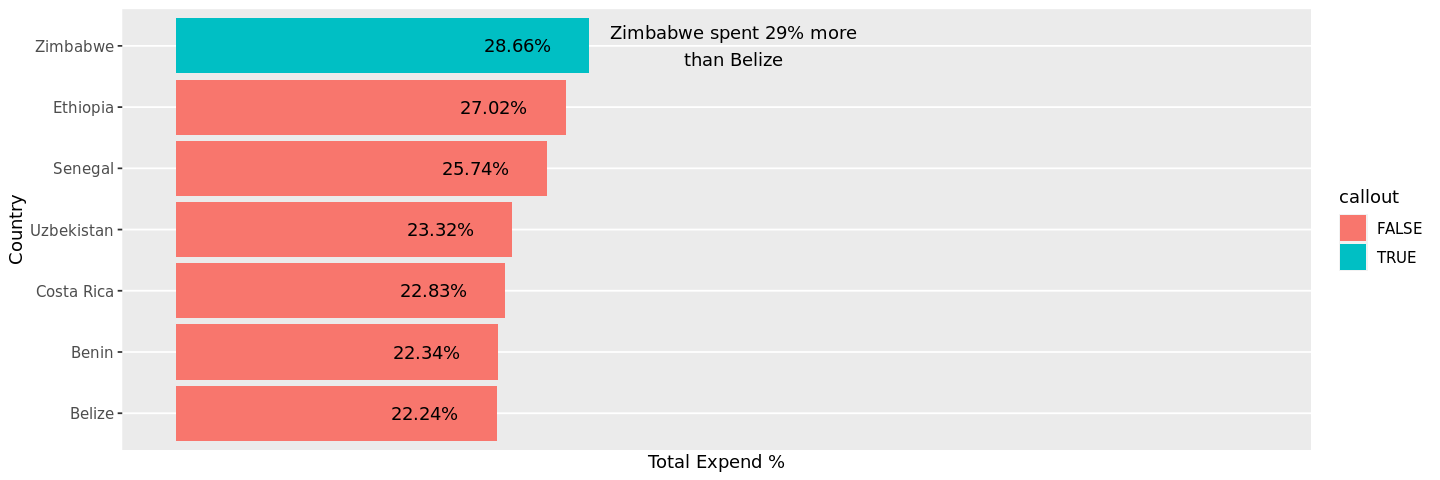

In [21]:
options(repr.plot.width=12, repr.plot.height=4)
p <- 
  ggplot(
    data = plotdata, 
    mapping = aes(x = `Country`, y = `Total Expend %`, fill = callout, label = percent(`Total Expend %`))
  ) +
  geom_bar(stat="identity", mapping = aes(fill = callout)) +
  geom_text(nudge_y = -0.05) +
  scale_y_continuous(limits = c(0,0.75), labels = NULL, breaks = NULL) +
  coord_flip() +
  annotate("text", label = label_val, x = countryToAnnotate[1], y = maxExpenditure + 0.1)
p

The ***chart title***, ***chart subtitle***, and ***chart caption*** is added using the ***labs*** function. ***labs*** is short for ***label***.

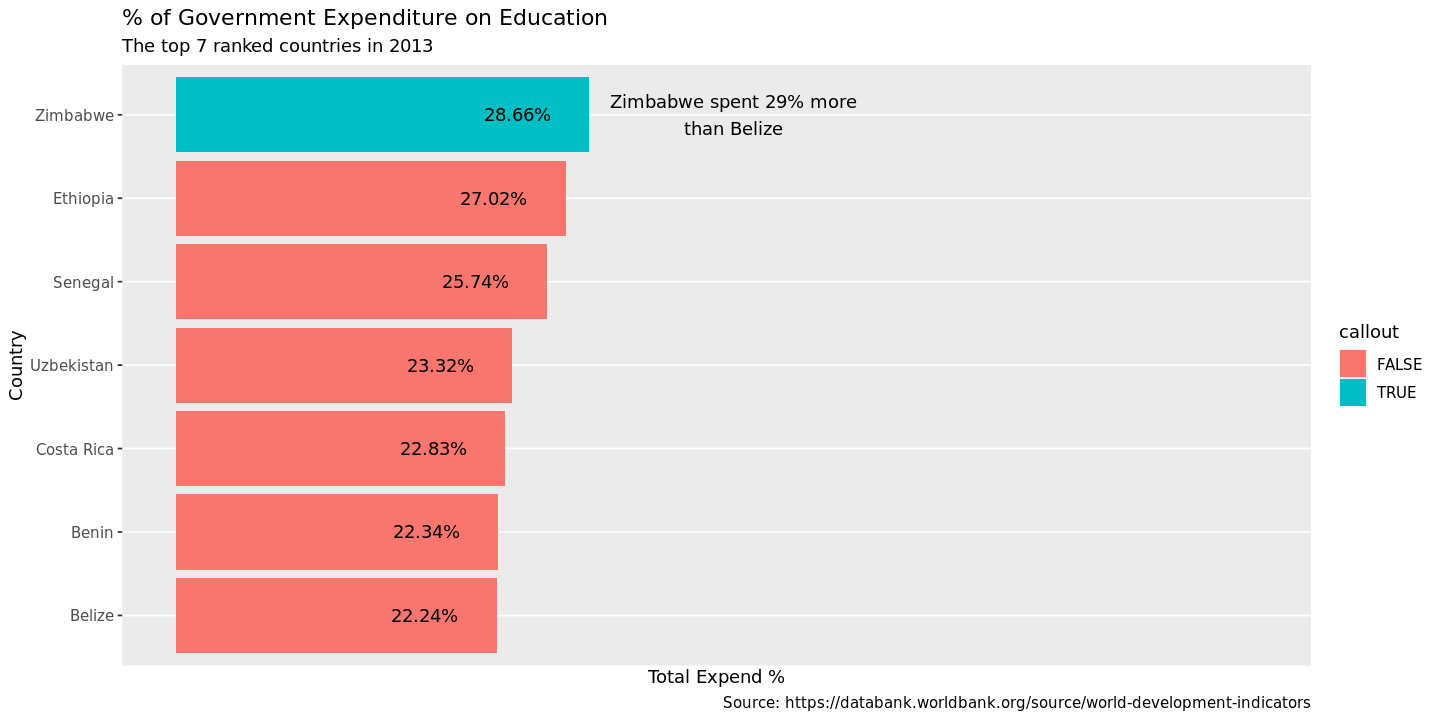

In [22]:
options(repr.plot.width=12, repr.plot.height=6)
p <- 
  ggplot(
    data = plotdata, 
    aes(x = `Country`, y = `Total Expend %`, fill = callout,   
        label = percent(`Total Expend %`))
  ) +
  geom_bar(stat="identity", aes(fill = callout)) +
  geom_text(nudge_y = -0.05) +
  scale_y_continuous(limits = c(0,0.75), labels = NULL, breaks = NULL) +
  coord_flip() +
  annotate("text", label = label_val, x = countryToAnnotate[1], y = maxExpenditure + 0.1) +
  labs(title = mainTitle, subtitle = subTitle, caption = caption)
p

Labels are not needed for the x-axis and y-axis. Neither is the chart legend. The axis labels are removed by setting the ***label*** argument in the ***xlab*** and ***ylab*** function to *NULL*. The legend is removed from the chart by setting the ***fill*** argument in the ***guides*** function to *FALSE*.

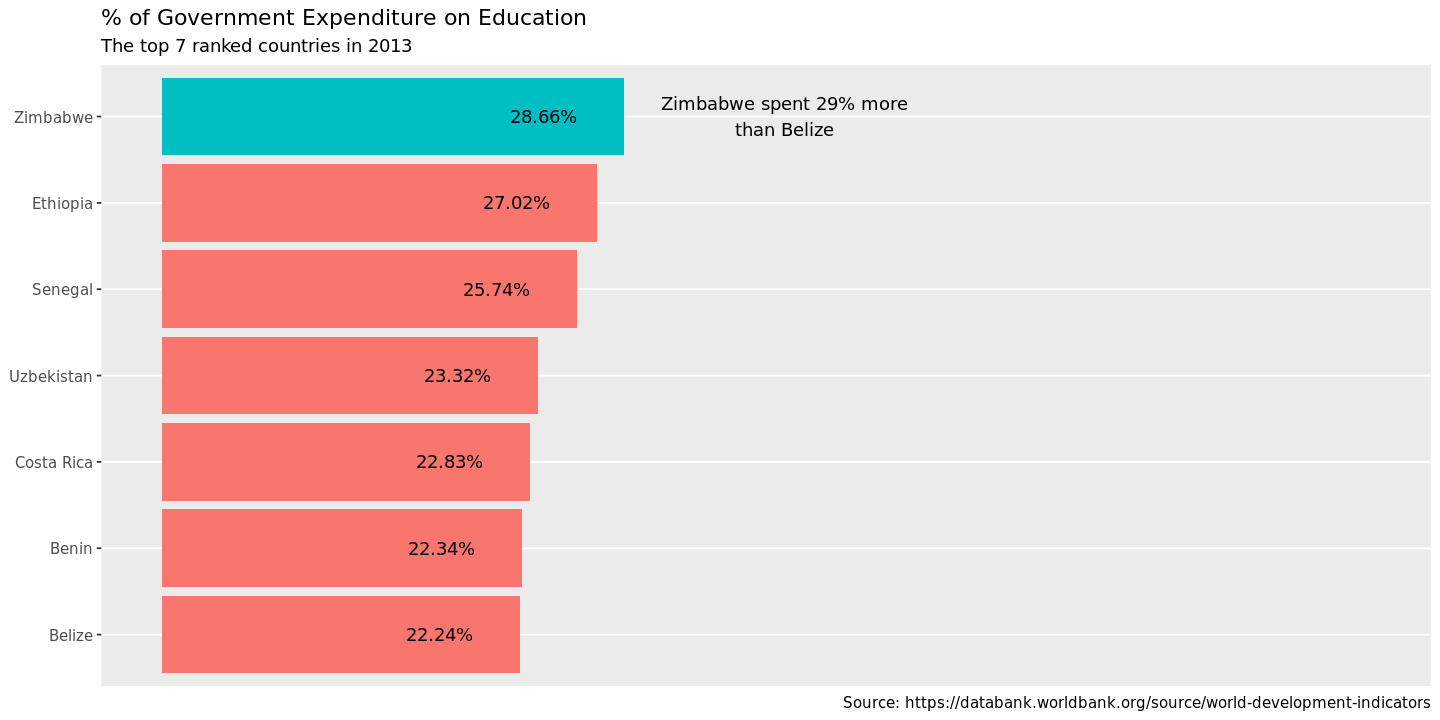

In [23]:
options(repr.plot.width=12, repr.plot.height=6)
p <- 
  ggplot(
    data = plotdata, 
    mapping = aes(x = `Country`, y = `Total Expend %`, fill = callout,   
        label = percent(`Total Expend %`))
  ) +
  geom_bar(stat="identity", mapping = aes(fill = callout)) +
  geom_text(nudge_y = -0.05) +
  scale_y_continuous(limits = c(0,0.75), labels = NULL, breaks = NULL) +
  coord_flip() +
  annotate("text", label = label_val, x = countryToAnnotate[1], y = maxExpenditure + 0.1) +
  labs(title = mainTitle, subtitle = subTitle, caption = caption) +
  xlab(label = NULL) +
  ylab(label = NULL) +
  guides(fill=FALSE)
p

Adds a theme chart based on principals developed by data visualization expert, Stephen Few.

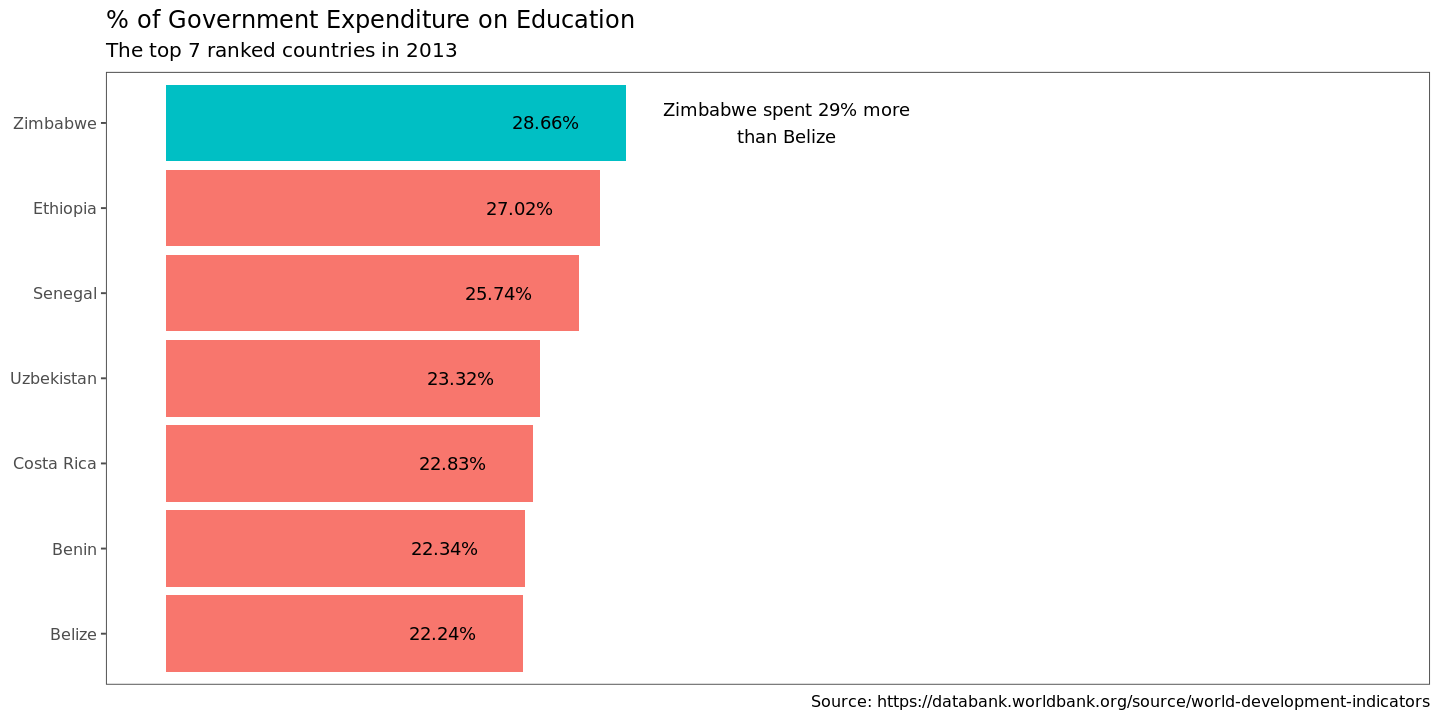

In [24]:
options(repr.plot.width=12, repr.plot.height=6)
p <- 
  ggplot(
    data = plotdata, 
    mapping = aes(x = `Country`, y = `Total Expend %`, fill = callout,   
        label = percent(`Total Expend %`))
  ) +
  geom_bar(stat="identity", mapping = aes(fill = callout)) +
  geom_text(nudge_y = -0.05) +
  scale_y_continuous(limits = c(0,0.75), labels = NULL, breaks = NULL) +
  coord_flip() +
  annotate("text", label = label_val, x = countryToAnnotate[1], y = maxExpenditure + 0.1) +
  labs(title = mainTitle, subtitle = subTitle, caption = caption) +
  xlab(label = NULL) +
  ylab(label = NULL) +
  guides(fill=FALSE) +
  theme_few()
p

Change the position of the chart title and chart subtitle of the chart via the theme() function. Mention the type of elemement_ function.

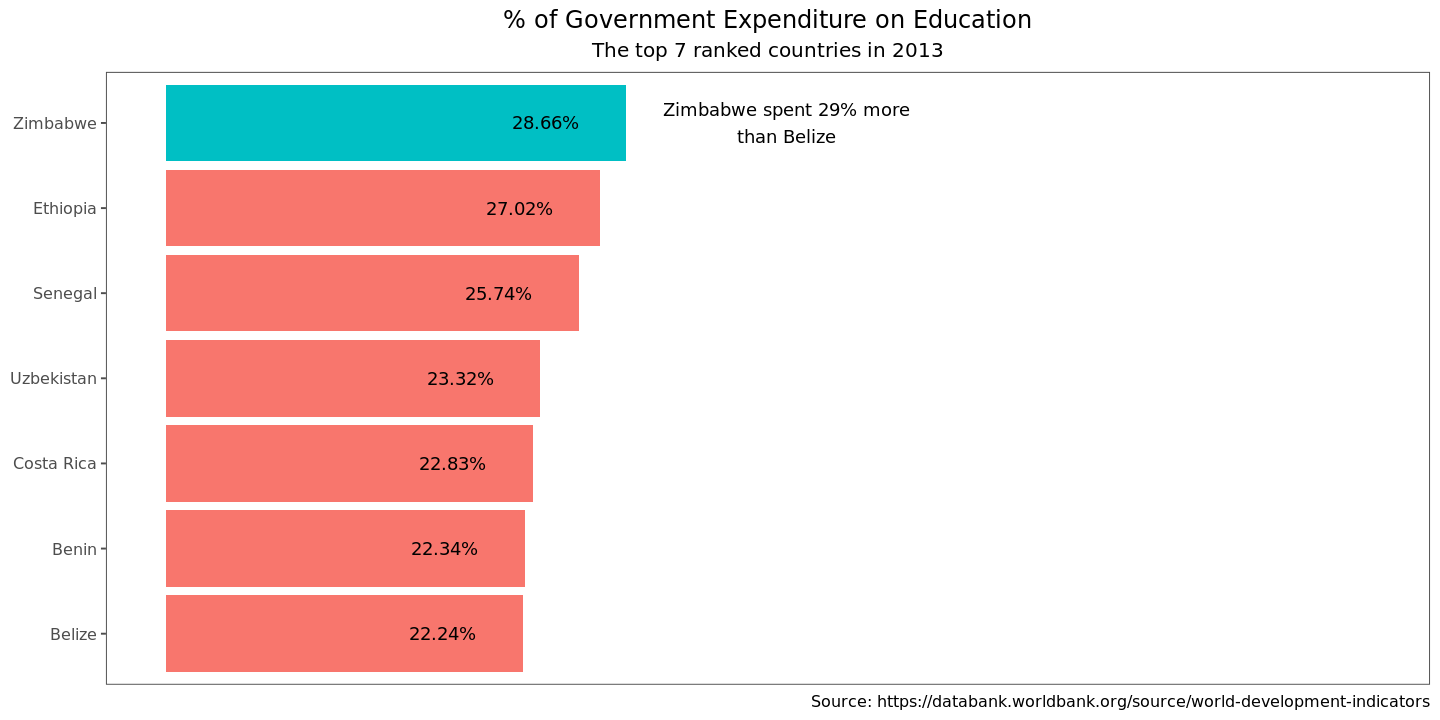

In [25]:
options(repr.plot.width=12, repr.plot.height=6)
p <- 
  ggplot(
    data = plotdata, 
    mapping = aes(x = `Country`, y = `Total Expend %`, fill = callout,   
        label = percent(`Total Expend %`))
  ) +
  geom_bar(stat="identity", mapping = aes(fill = callout)) +
  geom_text(nudge_y = -0.05) +
  scale_y_continuous(limits = c(0,0.75), labels = NULL, breaks = NULL) +
  coord_flip() +
  annotate("text", label = label_val, x = countryToAnnotate[1], y = maxExpenditure + 0.1) +
  labs(title = mainTitle, subtitle = subTitle, caption = caption) +
  xlab(label = NULL) +
  ylab(label = NULL) +
  guides(fill=FALSE) +
  theme_few() +
  theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5)
  )
p

# 6. Copy the complete R script to Power BI

# The Complete R Script

Below is the complete R script that uses the data passed from Power BI to build the callout chart with dynamic annotation. The script is fully functional so you can copy it and paste it in the R script editor in Power BI.

```R
library("ggplot2")
library("ggthemes")
library("dplyr")
library("forcats")
library("stringr")
library("scales")

currentColumns <- sort(colnames(dataset))
requiredColumns <- c("Country", "Total Expend %", "Year")
columnTest <- isTRUE(all.equal(currentColumns, requiredColumns))
reportYear <- unique(dataset$Year)

if (length(reportYear) == 1 & columnTest) {
  
  plotdata <- 
    dataset %>%
    mutate(
      rank = dense_rank(desc(`Total Expend %`)),
      `Country` = fct_reorder(`Country`, rank, .desc = TRUE), 
      callout = ifelse(rank == 1, TRUE, FALSE)
    ) %>%
    filter(rank <= 7)
  
  countryToAnnotate <- plotdata$`Country`[plotdata$rank == 1]
  minExpenditure <- min(plotdata$`Total Expend %`)
  maxExpenditure <- max(plotdata$`Total Expend %`)
  minCountry <- plotdata$`Country`[plotdata$`Total Expend %` == minExpenditure]
  minCountry <- paste(minCountry, collapse = " & ") 
  maxCountry <- plotdata$`Country`[plotdata$`Total Expend %` == maxExpenditure]
  maxCountry <- paste(maxCountry, collapse = " & ")
  mainTitle = "% of Government Expenditure on Education"
  subTitle = 
    paste(
      "The top 7 ranked countries in", 
      reportYear, 
      sep = " ")
  caption = "Source: https://databank.worldbank.org/source/world-development-indicators"
  
  label_val <- 
    str_wrap(
      paste(maxCountry, "spent",  
            percent((maxExpenditure/minExpenditure-1)), 
            "more than", minCountry, sep = " "),
      width = 25
    )
  
p <- 
  ggplot(
    data = plotdata, 
    mapping = aes(x = `Country`, y = `Total Expend %`, fill = callout, label = percent(`Total Expend %`))
    ) +
    geom_bar(stat="identity", mapping = aes(fill = callout)) +
    geom_text(nudge_y = -0.05) +
    scale_y_continuous(limits = c(0,0.75), labels = NULL, breaks = NULL) +
    coord_flip() +
    annotate("text", label = label_val, x = countryToAnnotate[1], y = maxExpenditure + 0.1) +
    labs(title = mainTitle, subtitle = subTitle, caption = caption) +
    xlab(label = NULL) +
    ylab(label = NULL) +
    guides(fill=FALSE) +
    theme_few() +
    theme(plot.title = element_text(hjust = 0.5), plot.subtitle = element_text(hjust = 0.5)
    )
  p
    
} else {
  plot.new()
  title("The data supplied did not meet the requirements of the chart.")
}
```